Yonaton chanowitz
07/21/2022
Data Science Flex
Instructor: Morgan Jones

Rainbow Six Siege is a highly competative first person shooter, where map knowledge, gadget usage, and operator loadout mean just as much as ability to shoot. Personally i don't have that high of a rank, nad wondered what would help me get an edge on the competition.

using the:
#### OSEMN 
method, 
let's find out which mixture of features leads to a win 

<font color='red'> The csv file included in this notebook is for demonstration purposes only. It is not the full file. running this notebook will not give you the total results without downloading the full set of files, which contains 20 csv files.  </font>

the full data set can be downloaded from here: https://www.kaggle.com/datasets/maxcobra/rainbow-six-siege-s5-ranked-dataset?resource=download&select=datadump_s5-000.csv 

In [1]:
# import neccessay libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

%matplotlib inline
import seaborn as sns


this data set is **HUGE**. i am going to run my models on about 2% of it, for computational speed

In [2]:
#i want to read all the columns
pd.set_option('display.max_columns', None)

# make a pandas dataframe using only 100,000 rows. 
first_set = pd.read_csv('r6s_data/datadump_s5-000.csv',  nrows=100000)
first_set.head(5)

,dateid,platform,gamemode,mapname,matchid,roundnumber,objectivelocation,winrole,endroundreason,roundduration,clearancelevel,skillrank,role,team,haswon,operator,nbkills,isdead,primaryweapon,primaryweapontype,primarysight,primarygrip,primaryunderbarrel,primarybarrel,secondaryweapon,secondaryweapontype,secondarysight,secondarygrip,secondaryunderbarrel,secondarybarrel,secondarygadget
0,20170212,PC,HOSTAGE,CLUB_HOUSE,1522380841,1,STRIP_CLUB,Defender,AttackersKilledHostage,124,64,Gold,Defender,1,1,SWAT-CASTLE,0,0,UMP45,Submachine_Guns,RedDot,Vertical,None,Compensator,5.7_USG,Pistols,None,None,None,None,IMPACT_GRENADE
1,20170212,PC,HOSTAGE,CLUB_HOUSE,1522380841,4,CHURCH,Defender,AttackersEliminated,217,81,Gold,Defender,0,1,GSG9-JAGER,0,1,416-C_CARBINE,Assault_Rifles,RedDot,Vertical,Laser,Suppressor,P12,Pistols,None,None,Laser,Suppressor,DEPLOYABLE_SHIELD
2,20170212,PC,HOSTAGE,CLUB_HOUSE,1522380841,3,CHURCH,Defender,AttackersEliminated,160,150,Gold,Defender,1,1,JTF2-FROST,0,0,9mm_C1,Submachine_Guns,Reflex,None,None,None,MK1_9mm,Pistols,None,None,None,None,DEPLOYABLE_SHIELD
3,20170212,PC,HOSTAGE,CLUB_HOUSE,1522380841,4,CHURCH,Defender,AttackersEliminated,217,94,Gold,Defender,0,1,BOPE-CAVEIRA,3,0,M12,Submachine_Guns,RedDot,None,None,MuzzleBrake,PRB92,Pistols,None,None,None,None,IMPACT_GRENADE
4,20170212,PC,HOSTAGE,CLUB_HOUSE,1522380841,6,BEDROOM,Attacker,DefendersEliminated,143,81,Gold,Defender,0,0,GSG9-JAGER,0,1,416-C_CARBINE,Assault_Rifles,RedDot,Vertical,Laser,Suppressor,P12,Pistols,None,None,Laser,Suppressor,DEPLOYABLE_SHIELD


In [3]:
# look at the column names and data types
first_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   dateid                100000 non-null  int64 
 1   platform              100000 non-null  object
 2   gamemode              100000 non-null  object
 3   mapname               100000 non-null  object
 4   matchid               100000 non-null  int64 
 5   roundnumber           100000 non-null  int64 
 6   objectivelocation     100000 non-null  object
 7   winrole               100000 non-null  object
 8   endroundreason        100000 non-null  object
 9   roundduration         100000 non-null  int64 
 10  clearancelevel        100000 non-null  int64 
 11  skillrank             100000 non-null  object
 12  role                  100000 non-null  object
 13  team                  100000 non-null  int64 
 14  haswon                100000 non-null  int64 
 15  operator          

In [4]:
# this is our target variable we will classify for
first_set['haswon'].unique()

array([1, 0], dtype=int64)

# data cleaning
1) we need to filter the DB to only `'gamemode' == 'BOMB'`, because in competitive play, only bomb is used

2) 'dateid' is useless, 
'roundduration', 'endroundreason', 'clearancelevel' and 'skillrank' are outcomes of wins, and will drop them

2a) 'haswon' is our target variable

3) ALL the variables here are categorical. need to use sklearn `OneHotEncoder`, which also means there is no need to scale the variables

In [5]:
only_bomb = first_set.loc[first_set['gamemode'] == 'BOMB']

In [6]:
# make a seperate dataframe with dummies just to generate a seaborn heatmap

# filtered = only_bomb.drop(['matchid', 'dateid', 'roundduration', 'endroundreason', 'clearancelevel', 'skillrank'], axis=1)
# dummy_bomb = pd.get_dummies(filtered)
# plt.figure(figsize=(10, 10))
# sns.heatmap(dummy_bomb.corr())

there truly is 0 correlation. this will be difficult to work with

In [7]:
#train test split, for later cross validation
y = only_bomb['haswon']
x = only_bomb.drop(['haswon', 'matchid', 'dateid', 'roundduration', 'endroundreason', 'clearancelevel', 'skillrank'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

In [12]:
# one hot encoding test and training sets
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore')

ohe.fit(x_train)
x_train_ohe = ohe.transform(x_train).toarray()
x_test_ohe = ohe.transform(x_test).toarray()

# Creating this DataFrame to show the result of the ohe, and plotting
ohe_train = pd.DataFrame(x_train_ohe, columns=ohe.get_feature_names_out(x_train.columns))

In [13]:
# use decision tree classifier for first model. 
# i want several leaf nodes, and entropy, because i assume there will be many positive values
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=7)
clf.fit(x_train_ohe, y_train)

DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=7)

let's see how well the clf model did

In [14]:
def prediction_scores(y_t, y_p):
    print(f"classification report {classification_report(y_t, y_p, output_dict=True)}")
    plt.figure(figsize=[8,8])
    sns.heatmap(confusion_matrix(y_t, y_p), annot=True)

classification report {'0': {'precision': 0.6800632911392405, 'recall': 1.0, 'f1-score': 0.8095686569975513, 'support': 6447}, '1': {'precision': 1.0, 'recall': 0.5460939838371744, 'f1-score': 0.7064175781628109, 'support': 6682}, 'accuracy': 0.7689846903800747, 'macro avg': {'precision': 0.8400316455696202, 'recall': 0.7730469919185872, 'f1-score': 0.7579931175801811, 'support': 13129}, 'weighted avg': {'precision': 0.8428949682363229, 'recall': 0.7689846903800747, 'f1-score': 0.7570699511727561, 'support': 13129}}


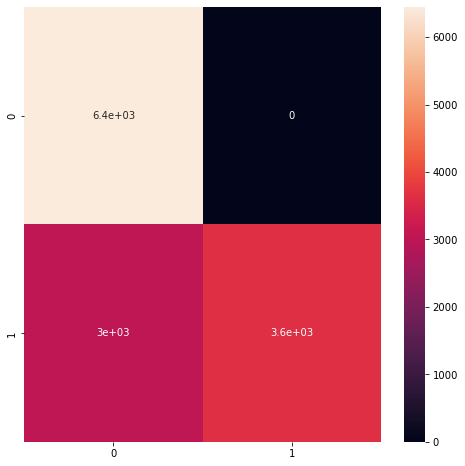

In [15]:
# get accuracy score, confusion matrix and classification report
y_preds = clf.predict(x_test_ohe)

prediction_scores(y_test, y_preds)

that's pretty good. i wonder if i can do better

In [16]:
# GridSearchCV
# get the ideal set of parameters from what i hypothesisze are good options
from sklearn.model_selection import GridSearchCV

clf_grid = DecisionTreeClassifier()

parameter_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 3, 5, 7],
    'min_samples_split': [2, 4, 8, 16]
}

grid_search_DTree = GridSearchCV(clf_grid, parameter_grid, cv=3)
grid_search_DTree.fit(x_train_ohe, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5, 7],
                         'min_samples_split': [2, 4, 8, 16]})

In [17]:
import joblib

with open('clf_grid.pkl', 'wb') as clfpkl:
    joblib.dump(grid_search_DTree, clfpkl)

In [18]:
with open('clf_grid.pkl', 'rb') as clfpkl:
    clf_cross = joblib.load(clfpkl)

In [19]:
clf_cross.best_params_

{'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 8}

the best parameters appear to be
`{'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 2}`

In [21]:
clf_after_grid = DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_split=4)
clf_after_grid.fit(x_train_ohe, y_train)

after_grid_predict = clf_after_grid.predict(x_test_ohe)

classification report {'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 6447}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 6682}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 13129}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 13129}}


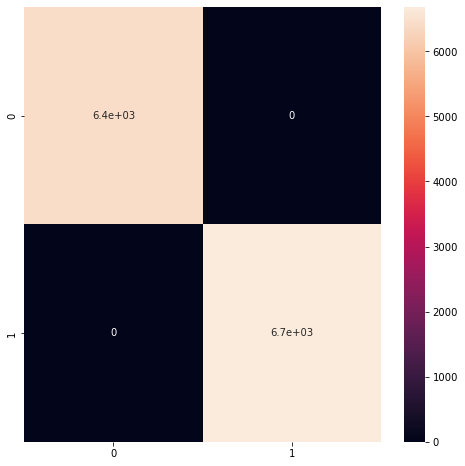

In [22]:
prediction_scores(y_test, after_grid_predict)

that's TOO good. not correct, must be overfit

the results of this 2018 data set, (which ubisoft knows about, and has since compensated for) is that being a defender is the biggest determining factor to winning more matches.

### Next model, KNN
lets use GridSearchCV again


In [23]:
#baseline knn model
from sklearn.neighbors import KNeighborsClassifier

# since i have so many 0 values (a sparse matrix) i have to use 'brute' method of weights, RAM heavy, but the only way i can
# get anything useful out of KNN

knn_baseline = KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='brute')

knn_baseline.fit(x_train_ohe, y_train)

KNeighborsClassifier(algorithm='brute', n_neighbors=3, weights='distance')

In [24]:
# pickle

with open('knn_base.pkl', 'wb') as knnpkl:
    joblib.dump(knn_baseline, knnpkl)

In [25]:
with open('knn_base.pkl', 'rb') as knnpkl:
    knn_base = joblib.load(knnpkl)

classification report {'0': {'precision': 0.905783168170389, 'recall': 0.9498991779122072, 'f1-score': 0.9273167777104785, 'support': 6447}, '1': {'precision': 0.9492776381909548, 'recall': 0.9046692607003891, 'f1-score': 0.9264367816091954, 'support': 6682}, 'accuracy': 0.9268794272221799, 'macro avg': {'precision': 0.9275304031806719, 'recall': 0.9272842193062982, 'f1-score': 0.926876779659837, 'support': 13129}, 'weighted avg': {'precision': 0.9279196636138668, 'recall': 0.9268794272221799, 'f1-score': 0.9268689039997028, 'support': 13129}}


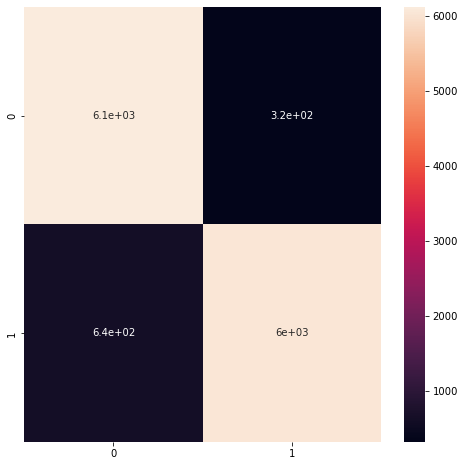

In [27]:
knn_predict = knn_base.predict(x_test_ohe)

prediction_scores(y_test, knn_predict)

similar overfitting. going to try `GridSearch` on this model, just for consistency

In [28]:
# make a KNN model with gridsearch to get best parameters
knn_params = {
    'n_neighbors': [3, 5, 7],
    'algorithm': ['ball_tree', 'kd_tree'],
    'p':[1, 2]
}

knn = KNeighborsClassifier()

grid_search_knn = GridSearchCV(knn, knn_params, cv=3)
grid_search_knn.fit(x_train_ohe, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree'],
                         'n_neighbors': [3, 5, 7], 'p': [1, 2]})

In [30]:
with open('knn_grid.pkl', 'wb') as knnpkl:
    joblib.dump(grid_search_knn, knnpkl)

In [31]:
with open('clf_grid.pkl', 'rb') as knnpkl:
    knn_grid = joblib.load(knnpkl)

In [32]:
knn_grid.best_params_

{'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 8}

Random Forest model

using RandomForest to get the best of both worlds

In [33]:
# RandomForest and Pipeline, because i want to refactor my final model into a pipeline
# hopefully send it to some other players :->
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

random_forest_one = RandomForestClassifier(random_state=123)
random_pipe = Pipeline([('RF', RandomForestClassifier(random_state=123))])

In [34]:
go strainght to gridsearch with the random forest
grid = [{'RF__max_depth': [4, 5, 6], 
         'RF__min_samples_split': [2, 5], 
         'RF__min_samples_leaf': [1, 3, 5]}]

grid_forest = GridSearchCV(estimator=random_pipe, param_grid=grid, scoring='accuracy', cv=5)

In [35]:
grid_forest.fit(x_train_ohe, y_train)
grid_forest.score(x_test_ohe, y_test)

0.7743925660751009

In [36]:
grid_forest.best_params_

{'RF__max_depth': 6, 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 2}

{'RF__max_depth': 6, 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 2}

In [37]:
final_forest = RandomForestClassifier(max_depth=6, min_samples_leaf=1, min_samples_split=2)

In [38]:
final_forest.fit(x_train_ohe, y_train)

RandomForestClassifier(max_depth=6)

In [39]:
with open('forest_final.pkl', 'wb') as fopkl:
    joblib.dump(final_forest, fopkl)

In [40]:
with open('forest_final.pkl', 'rb') as fopkl:
    fo_fin = joblib.load('forest_final.pkl')

In [42]:
forest_pred = fo_fin.predict(x_test_ohe)

classification report {'0': {'precision': 0.7030193780982424, 'recall': 0.9678920428106096, 'f1-score': 0.8144619199895582, 'support': 6447}, '1': {'precision': 0.95132847401834, 'recall': 0.6055073331337922, 'f1-score': 0.7400091449474165, 'support': 6682}, 'accuracy': 0.7834564704090182, 'macro avg': {'precision': 0.8271739260582912, 'recall': 0.7866996879722009, 'f1-score': 0.7772355324684874, 'support': 13129}, 'weighted avg': {'precision': 0.8293962064125155, 'recall': 0.7834564704090182, 'f1-score': 0.776569205934292, 'support': 13129}}


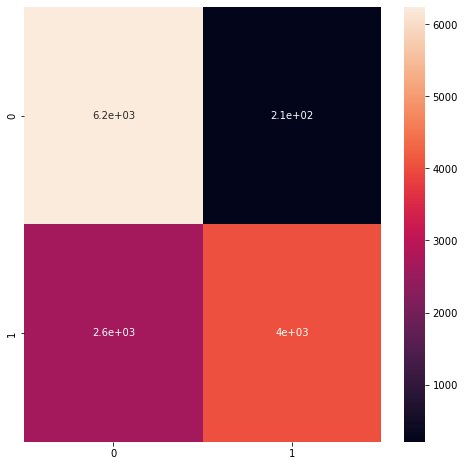

In [43]:
prediction_scores(y_test, forest_pred)

and we get what we wanted. a model that gets more false negatives than false positives. players will prefer to be told they wil lose, and win, than told they will win and lose

In [45]:
# make a dataframe to get data for a bar chart, for my presentation
display_df = pd.DataFrame(data=[final_forest.feature_importances_ ], columns=ohe_train.columns.values)
display_df.head(15)

,platform_PC,platform_PS4,platform_XONE,gamemode_BOMB,mapname_BANK,mapname_BARTLETT_U.,mapname_BORDER,mapname_CHALET,mapname_CLUB_HOUSE,mapname_COASTLINE,mapname_CONSULATE,mapname_FAVELAS,mapname_HEREFORD_BASE,mapname_HOUSE,mapname_KAFE_DOSTOYEVSKY,mapname_KANAL,mapname_OREGON,mapname_PLANE,mapname_SKYSCRAPER,mapname_YACHT,roundnumber_1,roundnumber_2,roundnumber_3,roundnumber_4,roundnumber_5,roundnumber_6,roundnumber_7,roundnumber_8,roundnumber_9,objectivelocation_1F_BBQ-1F_KITCHEN,objectivelocation_1F_BEDROOM-1F_BATHROOM,objectivelocation_1F_BIKER'S_APARTMENT-1F_BIKER'S_BEDROOM,objectivelocation_1F_BLUE_BAR-1F_SUNRISE_BAR,objectivelocation_1F_KITCHEN-1F_SERVICE_ENTRANCE,objectivelocation_2F_AUNT'S_BEDROOM-1F_AUNT'S_APARTMENT,objectivelocation_2F_EXHIBITION-2F_WORK_OFFICE,objectivelocation_2F_FOOTBALL_BEDROOM-2F_FOOTBALL_OFFICE,objectivelocation_2F_HOOKAH_LOUNGE-2F_BILLIARDS_ROOM,objectivelocation_2F_KARAOKE-2F_TEA_ROOM,objectivelocation_2F_PENTHOUSE-2F_THEATER,objectivelocation_3F_PACKAGING_ROOM-2F_METH_LAB,objectivelocation_ARMORY_LOCKERS-ARCHIVES,objectivelocation_BAR-COCKTAIL_LOUNGE,objectivelocation_BAR-GAMING_ROOM,objectivelocation_BAR-STOCK_ROOM,objectivelocation_BATHROOM-TELLERS,objectivelocation_BRIEFING_ROOM-ARMORY,objectivelocation_CAFETERIA-STAFF_DORMITORY,objectivelocation_CARGO_HOLD-LUGGAGE_HOLD,objectivelocation_CCTV_ROOM-CASH_ROOM,objectivelocation_CHURCH-ARSENAL_ROOM,objectivelocation_CLASSROOM-LIBRARY,objectivelocation_COAST_GUARD_OFFICE-HOLDING_ROOM,objectivelocation_CONSUL_OFFICE-MEEETING_ROOM,objectivelocation_CUSTOMS_INSPECTIONS-SUPPLY_ROOM,objectivelocation_DINING_ROOM-KIDS_BEDROOM,objectivelocation_DUMMY_DEPOT-STORAGE,objectivelocation_EXECUTIVE_LOUNGE-CEO_OFFICE,objectivelocation_FIREPLACE_HALL-MINING_ROOM,objectivelocation_GARAGE-CAFETERIA,objectivelocation_GYM-BEDROOM,objectivelocation_KID'S_BEDROOM-WORKSHOP,objectivelocation_KIDS_DORMS-DORMS_MAIN_HALL,objectivelocation_KITCHEN-DINING_HALL,objectivelocation_KITCHEN-ENGINE_CONTROL,objectivelocation_KITCHEN-PIANO_ROOM,objectivelocation_KITCHEN-PROJECTOR_ROOM,objectivelocation_KITCHEN-TROPHY_ROOM,objectivelocation_KITCHEN_PREP-BAKERY,objectivelocation_LAUDRY_ROOM-SUPPLY_ROOM,objectivelocation_LIVING_ROOM-TRAINING_ROOM,objectivelocation_LOBBY-PRESS_ROOM,objectivelocation_LOCKERS-CCTV_ROOM,objectivelocation_MAPS_ROOM-COCKPIT,objectivelocation_MASTER_BEDROOM-OFFICE,objectivelocation_MEETING_ROOM-EXECUTIVE_OFFICE,objectivelocation_READING_ROOM-LIBRARY,objectivelocation_REAR_STAGE-WATCH_TOWER,objectivelocation_ROWING_MUSEUM-TROPHY_ROOM,objectivelocation_SERVER_ROOM-CONTROL_ROOM,objectivelocation_SERVER_ROOM-ENGINE_STORAGE,objectivelocation_STAFF_ROOM-OPEN_AREA,objectivelocation_STAFF_SECTION-EXECUTIVE_BEDROOM,objectivelocation_TELLERS'_OFFICE-ARCHIVES,objectivelocation_TRAINING_ROOM-GARAGE,objectivelocation_TV_ROOM-KITCHEN,objectivelocation_VENTILATION_ROOM-WORKSHOP,objectivelocation_WINE_CELLAR-SNOWMOBILE_GARAGE,winrole_Attacker,winrole_Defender,role_Attacker,role_Defender,team_0,team_1,operator_BOPE-CAPITAO,operator_BOPE-CAVEIRA,operator_G.E.O.-JACKAL,operator_G.E.O.-MIRA,operator_GIGN-DOC,operator_GIGN-MONTAGNE,operator_GIGN-RESERVE,operator_GIGN-ROOK,operator_GIGN-TWITCH,operator_GSG9-BANDIT,operator_GSG9-BLITZ,operator_GSG9-IQ,operator_GSG9-JAGER,operator_GSG9-RESERVE,operator_JTF2-BUCK,operator_JTF2-FROST,operator_NAVYSEAL-BLACKBEARD,operator_NAVYSEAL-VALKYRIE,operator_SAS-MUTE,operator_SAS-RESERVE,operator_SAS-SLEDGE,operator_SAS-SMOKE,operator_SAS-THATCHER,operator_SAT-ECHO,operator_SAT-HIBANA,operator_SPETSNAZ-FUZE,operator_SPETSNAZ-GLAZ,operator_SPETSNAZ-KAPKAN,operator_SPETSNAZ-RESERVE,operator_SPETSNAZ-TACHANKA,operator_SWAT-ASH,operator_SWAT-CASTLE,operator_SWAT-PULSE,operator_SWAT-RESERVE,operator_SWAT-THERMITE,nbkills_0,nbkills_1,nbkills_2,nbkills_3,nbkills_4,nbkills_5,isdead_0,isdead_1,primaryweapon_416-C_CARBINE,primaryweapon_552_COMMANDO,primaryweapon_556XI,primaryweapon_6P41,primaryweapon_9mm_C1,primaryweapon_9x19VSN,primaryweapon_AK-12,pr

let's see which features are most important

In [53]:
# take the most useful columns to display
actually_useful = display_df.loc[:, (display_df.iloc[-1] > 0.01)]

actually_useful

,winrole_Attacker,winrole_Defender,role_Attacker,role_Defender,nbkills_0,nbkills_2,nbkills_3,nbkills_4,isdead_0,isdead_1,primaryweapontype_Submachine_Guns
0,0.043006,0.04563,0.028226,0.024578,0.054155,0.037035,0.034497,0.012826,0.247139,0.311643,0.017666


<AxesSubplot:>

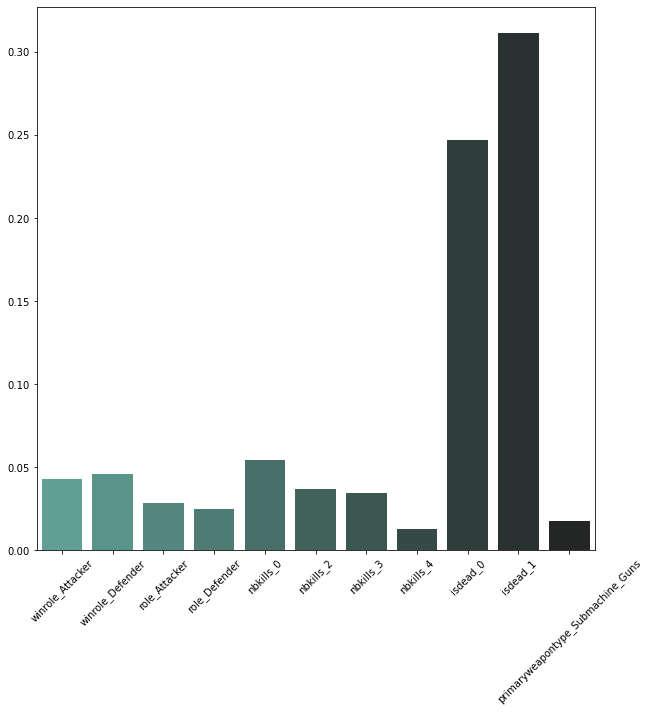

In [61]:
# make a barplot of the useful features
plt.figure(figsize=(10, 10))
plt.xticks(rotation=45)
sns.barplot(data=actually_useful, palette="dark:#5A9_r")